<a href="https://colab.research.google.com/github/nikshcherbakov/NoFloodWithAI/blob/main/NoFloodWithAISolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Предсказание уровней воды на реке Амур

In [4]:
# Установка требуемых пакетов для Collab
!pip install shap

     |████████████████████████████████| 327kB 12.5MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463910 sha256=93bb4dcaae021ed4163995507275d4b2cf7b48b86187628a9702a040fbc2d566
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


In [5]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV

In [6]:
# Путь до папки с данными
path_to_data = '/content/drive/My Drive/Colab Notebooks/datasets/'

Определяем период, на который будем предсказывать (в нашем случае это первые 10 дней ноября 2019 года)

In [7]:
predict_period = ['2019-11-01', '2019-11-11'] 
# predict_period = ['2020-01-01', '2020-01-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

In [8]:
predict_ndays

10

 Загрузка данных об уровнях воды на гидропостах.
 
 Датасет `daily.pkl` - собран из всех файлов `{номер_станции}_daily.csv` из папки 'datasets/', 
 номер гидропоста записан в отдельной колонке. Колонки приведены к соответствующим форматам, датасет отсортирован по (номеру гидропоста, дате)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
daily = pd.read_pickle(path_to_data + 'processed_data/daily.pkl')

In [12]:
daily = daily.sort_values(by=['station_id','date'])
daily = daily.reset_index(drop=True)

In [13]:
daily

,date,stage_avg,stage_min,stage_max,temp,water_code,station_id
0,1984-01-01,258.0,258.0,258.0,NaN,NaN,5001
1,1984-01-02,255.0,255.0,255.0,NaN,NaN,5001
2,1984-01-03,252.0,252.0,252.0,NaN,NaN,5001
3,1984-01-04,248.0,248.0,248.0,NaN,NaN,5001
4,1984-01-05,244.0,244.0,244.0,NaN,NaN,5001
...,...,...,...,...,...,...,...
2201366,2017-12-27,10.0,10.0,10.0,NaN,18.0,6574
2201367,2017-12-28,10.0,10.0,10.0,NaN,18.0,6574
2201368,2017-12-29,9.0,9.0,9.0,NaN,18.0,6574
2201369,2017-12-30,9.0,9.0,9.0,NaN,18.0,6574


In [14]:
# Выбираем целевые гидрологические посты
station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]
daily = daily[daily['station_id'].isin(station_ids)]

Посмотрим как выглядит ряд для фиксированного `station_id`

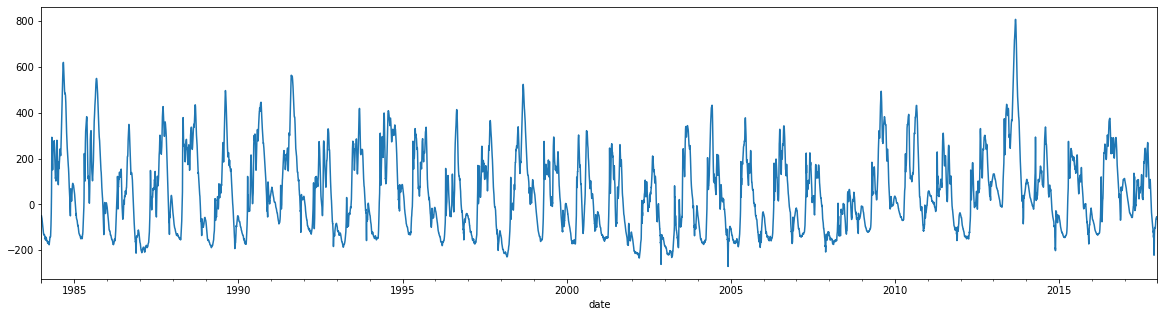

In [15]:
daily = daily.set_index('date')
daily.loc[daily['station_id'] == 5012, 'stage_max'].plot(figsize=(20, 5))
daily = daily.reset_index()

Загрузим и приведем к соответствующим форматам свежие данные по целевым вышкам, которые находятся в файле `datasets/hydro2019-20/new_data.csv`

In [16]:
nf = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_target.csv', sep=';')

In [17]:
nf

,time,max_level,identifier
0,2020-10-01 00:00:00,799.0,5004
1,2020-10-01 00:00:00,203.0,5805
2,2020-10-01 00:00:00,704.0,5024
3,2020-10-01 00:00:00,521.0,5012
4,2020-10-01 00:00:00,363.0,6005
...,...,...,...
105852,2018-10-27 00:00:00,309.0,5004
105853,2018-05-04 00:00:00,59.0,6296
105854,2018-10-16 00:00:00,93.0,5012
105855,2019-05-25 00:00:00,28.0,5024


In [18]:
nf['time'] = pd.to_datetime(nf['time'], format='%Y-%m-%d %H:%M:%S')
nf.columns = ['date', 'stage_max', 'station_id']
nf = nf.sort_values(by=['station_id', 'date'])
nf = nf.set_index('date')
nf = nf[nf.index > '2017-12-31']

Посмотрим на графики новых данных:

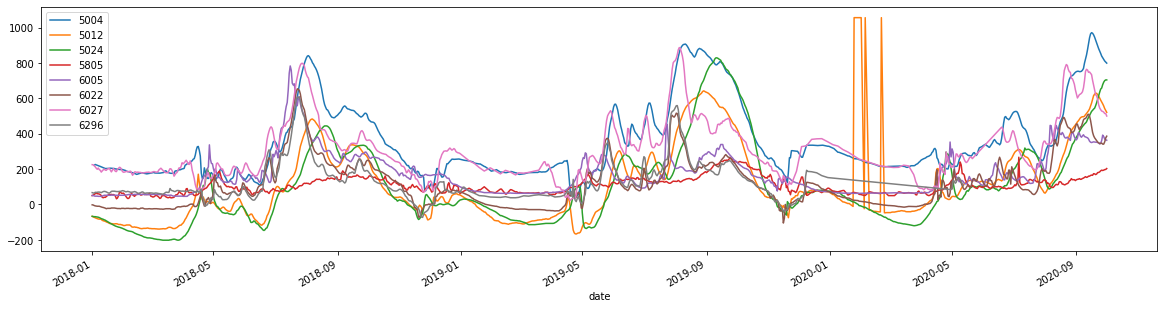

In [19]:
plt.figure(figsize=(20,5))
leg = []
for st in nf.station_id.unique():
    sf = nf[nf['station_id'] == st]
    sf['stage_max'].plot()
    leg.append(st)
plt.legend(leg)

Удалим выбросы у гидрологичского поста с номером 5012

In [20]:
nf.loc[(nf['stage_max'] > nf['stage_max'].\
          quantile(0.99))&(nf['station_id'] == 5012), 'stage_max'] = np.nan

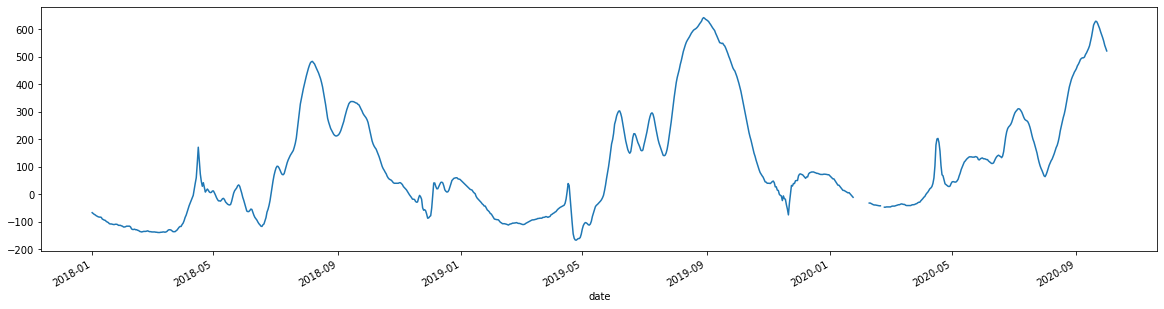

In [21]:
sf = nf[nf['station_id'] == 5012]
sf['stage_max'].plot(figsize=(20,5))

Приведем индексы к такому же виду как в daily и соеденим датасеты 

In [22]:
nf = nf.reset_index()
nf = nf.reindex(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id'], axis=1)
daily = pd.concat([daily, nf], axis=0)
daily = daily.sort_values(by=['station_id', 'date'])

### Метеоданные 
Рассмотрим описания исходных данных

In [23]:
s2m = pd.read_pickle(path_to_data + 'processed_data/s2m.pkl')
s2m.head()

,meteo_id,dist
station_id,,
5674,4943321,81.846330
5216,4433241,21.467114
6256,5172691,62.347672
5132,4483421,27.216443
5151,4393311,1.111949


In [24]:
s2m.loc[station_ids]

,meteo_id,dist
station_id,,
6005,5352391,1.432991
6022,5032761,3.730040
6027,4943011,31.894002
5004,4713431,163.722606
5012,4853511,7.293897
5024,5053701,1.413675
5805,5244051,83.986906


In [26]:
pd.read_csv(path_to_data + 'meteo/4263131.csv', sep=';').describe()

,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality
count,93008.0,29246.000000,93008.000000,85834.000000,93008.000000,85500.000000,93008.000000,0.0,77687.000000,93008.000000,2.0,4345.000000,93008.000000,55364.000000,93008.000000,88639.000000,93008.000000,73993.000000,93008.000000
mean,4263131.0,78.350133,3.846734,188.715556,0.462799,4.371205,0.486281,NaN,9.118064,1.008580,0.0,4.421312,4.766622,8.146323,2.461229,6.533772,0.337949,69.534280,1.227056
std,0.0,25.166109,2.636317,107.398418,1.600824,2.934899,1.635085,NaN,4.402840,2.224532,0.0,9.065587,1.055302,12.580620,2.928933,10.447699,1.299652,23.467071,2.419749
min,4263131.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000,0.000000,-25.000000,0.000000,-24.200000,0.000000,1.000000,0.000000
25%,4263131.0,79.000000,0.000000,90.000000,0.000000,2.000000,0.000000,NaN,6.000000,0.000000,0.0,0.200000,5.000000,-1.500000,0.000000,-2.000000,0.000000,49.000000,0.000000
50%,4263131.0,82.000000,5.000000,230.000000,0.000000,4.000000,0.000000,NaN,8.000000,0.000000,0.0,1.000000,5.000000,8.400000,0.000000,7.200000,0.000000,71.000000,0.000000
75%,4263131.0,98.000000,6.000000,270.000000,0.000000,6.000000,0.000000,NaN,12.000000,0.000000,0.0,4.300000,5.000000,17.400000,6.000000,15.700000,0.000000,92.000000,0.000000
max,4263131.0,99.000000,6.000000,999.000000,6.000000,37.000000,6.000000,NaN,40.000000,6.000000,0.0,140.000000,6.000000,55.000000,6.000000,30.900000,6.000000,100.000000,6.000000


In [27]:
# Вспомогательная функция для соединения идентичных датафреймов 
def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

Считываем файлы с метеоданными, соответствующие целевым гидрологическим постам. Номер метеостанции записываем в колонку `meteo_id`, а номер гидрологического поста в `station_id`

In [28]:
meteo = None
for s, m in s2m.loc[station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    df = pd.read_csv(path_to_data + 'meteo/{}.csv'.format(m), sep=';').rename({'station_id': 
                                                                                        'meteo_id'}, axis=1)
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['datetime'].apply(lambda x: x.date())
    df['station_id'] = s
    meteo = weary_append(meteo, df)

In [29]:
meteo.head(50)

,station_name,meteo_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time,datetime,date,station_id
0,DJALI25,5352391,96.0,0,315.0,0,4.0,0,NaN,6.0,0,NaN,NaN,5,-1.3,0,-5.7,0,87.0,0,2013-04-17 21:00:00,2013-04-17 21:00:00,2013-04-17,6005
1,DJALI25,5352391,NaN,5,315.0,0,4.0,0,NaN,6.0,0,NaN,NaN,5,-1.4,0,-4.7,0,63.0,0,2013-04-17 18:00:00,2013-04-17 18:00:00,2013-04-17,6005
2,DJALI25,5352391,NaN,5,315.0,0,4.0,0,NaN,7.0,0,NaN,NaN,5,-0.8,0,-2.5,0,49.0,0,2013-04-17 15:00:00,2013-04-17 15:00:00,2013-04-17,6005
3,DJALI25,5352391,NaN,5,315.0,0,3.0,0,NaN,4.0,0,NaN,3.2,0,-1.2,0,-0.9,0,99.0,0,2013-04-17 12:00:00,2013-04-17 12:00:00,2013-04-17,6005
4,DJALI25,5352391,96.0,0,315.0,0,3.0,0,NaN,4.0,0,NaN,NaN,5,0.4,0,-0.1,0,96.0,0,2013-04-17 09:00:00,2013-04-17 09:00:00,2013-04-17,6005
5,DJALI25,5352391,97.0,0,315.0,0,4.0,0,NaN,6.0,0,NaN,NaN,5,5.0,0,2.1,0,62.0,0,2013-04-17 06:00:00,2013-04-17 06:00:00,2013-04-17,6005
6,DJALI25,5352391,97.0,0,292.0,0,3.0,0,NaN,5.0,0,NaN,NaN,5,-0.2,0,-1.3,0,77.0,0,2013-04-17 03:00:00,2013-04-17 03:00:00,2013-04-17,6005
7,DJALI25,5352391,96.0,0,315.0,0,4.0,0,NaN,5.0,0,NaN,1.5,0,-0.3,0,-5.5,0,90.0,0,2013-04-17 00:00:00,2013-04-17 00:00:00,2013-04-17,6005
8,DJALI25,5352391,98.0,0,315.0,0,6.0,0,NaN,10.0,0,NaN,NaN,5,-0.9,0,-2.7,0,61.0,0,2013-04-16 21:00:00,2013-04-16 21:00:00,2013-04-16,6005
9,DJALI25,5352391,NaN,5,315.0,0,5.0,0,NaN,10.0,0,NaN,NaN,5,-1.0,0,-3.4,0,64.0,0,2013-04-16 18:00:00,2013-04-16 18:00:00,2013-04-16,6005


### Новые метеоданные

In [30]:
meteo_new = None
for s, m in s2m.loc[station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    try:
        df = pd.read_csv(path_to_data + 'meteo_new/{}.csv'.format(m))
        
        df['datetime'] = [datetime(year=x[0], month=x[1], day=x[2], hour=x[3]) 
                      for x in zip(df['year'].values, df['month'].values, df['day'].values, df['time'].values)]
        
        df = df[['stationId', 'horizontalVisibility', 'horizontalVisibilityQuality', 'windDirection', 
                 'windDirectionQuality', 'windSpeed', 'windSpeedQuality', 'windSpeedSign', 
                 'maximumWindGustSpeed', 'maximumWindGustSpeedQuality', 'maximumWindGustSpeedSign', 
                 'totalAccumulatedPrecipitation', 'totalAccumulatedPrecipitationQuality', 
                 'soilTemperature', 'soilTemperatureQuality', 'airTemperature', 'airTemperatureQuality',
                 'relativeHumidity', 'relativeHumidityQuality', 'datetime']]. \
        rename(columns={'stationId': 'meteo_id',
                        'horizontalVisibility': 'visibility_distance',
                        'horizontalVisibilityQuality': 'visibility_distance_quality',
                        'windDirection': 'wind_direction',
                        'windDirectionQuality': 'wind_direction_quality',
                        'windSpeed': 'wind_speed_avg',
                        'windSpeedQuality': 'wind_speed_avg_quality',
                        'windSpeedSign': 'wind_speed_sign',
                        'maximumWindGustSpeed': 'wind_speed_max',
                        'maximumWindGustSpeedQuality': 'wind_speed_max_quality',
                        'maximumWindGustSpeedSign': 'wind_speed_max_sign',
                        'totalAccumulatedPrecipitation': 'precipitation_amount',
                        'totalAccumulatedPrecipitationQuality': 'precipitation_amount_quality',
                        'soilTemperature': 'temperature_ground',
                        'soilTemperatureQuality': 'temperature_ground_quality',
                        'airTemperature': 'temperature_air',
                        'airTemperatureQuality': 'temperature_air_quality',
                        'relativeHumidity': 'humidity',
                        'relativeHumidityQuality': 'humidity_quality'})
        
        df['date'] = df['datetime'].apply(lambda x: x.date())
        df['station_id'] = s
        print(f'File {m}.csv shape: {df.shape}')
        meteo_new = weary_append(meteo_new, df)
    except FileNotFoundError:
        print(f'Not found file: {m}.csv')

File 5352391.csv shape: (105917, 22)
File 5032761.csv shape: (105917, 22)
File 4943011.csv shape: (105917, 22)
File 4713431.csv shape: (105916, 22)
Not found file: 4853511.csv
Not found file: 5053701.csv
File 5244051.csv shape: (105420, 22)


Отбираем необходимые данные из `meteo_new` для соедениения с `meteo`

In [31]:
meteo_from_2019 = meteo_new[meteo_new['date'] > datetime(2018, 12, 31).date()]
meteo_from_2019

,meteo_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,datetime,date,station_id
102272,5352391,NaN,0,335.0,0,4.0,0,0,12.0,0,0,0.0,5,-16.2,0,-16.2,0,53.0,0,2019-01-01 00:00:00,2019-01-01,6005
102273,5352391,NaN,0,341.0,0,3.0,0,0,9.0,0,0,0.0,5,-15.2,0,-15.2,0,49.0,0,2019-01-01 03:00:00,2019-01-01,6005
102274,5352391,NaN,0,5.0,0,1.0,0,0,6.0,0,0,0.0,5,-15.2,0,-12.5,0,43.0,0,2019-01-01 06:00:00,2019-01-01,6005
102275,5352391,NaN,5,333.0,0,1.0,0,0,4.0,0,0,0.0,5,-25.1,0,-21.4,0,73.0,0,2019-01-01 09:00:00,2019-01-01,6005
102276,5352391,NaN,5,289.0,0,1.0,0,0,3.0,0,0,0.0,5,-29.1,0,-25.4,0,78.0,0,2019-01-01 12:00:00,2019-01-01,6005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105415,5244051,NaN,5,37.0,0,1.0,0,0,2.0,0,0,0.0,5,-28.5,0,-22.5,0,75.0,0,2020-02-28 21:00:00,2020-02-28,5805
105416,5244051,NaN,0,0.0,0,0.0,0,0,2.0,0,0,0.0,5,-20.4,0,-16.6,0,62.0,0,2020-02-29 00:00:00,2020-02-29,5805
105417,5244051,NaN,0,185.0,0,1.0,0,0,3.0,0,0,0.0,5,-11.0,0,-12.6,0,51.0,0,2020-02-29 03:00:00,2020-02-29,5805
105418,5244051,NaN,0,192.0,0,1.0,0,0,3.0,0,0,0.0,5,-9.5,0,-8.4,0,46.0,0,2020-02-29 06:00:00,2020-02-29,5805


Заполняем таблицу `meteo_from_2019` значениями `NaN` для пропущенных дат

In [32]:
# Функция для заполнения отсутствующих дат знчениями NaN
def fill_missing_dates_with_nans(df, dates):
    res_df = pd.DataFrame()
    dates = pd.DataFrame(dates, columns=['date'])
    
    for station_id in station_ids:
        df1 = df[df['station_id'] == station_id]
        df1 = dates.merge(df1, on=['date'], how='left')
        df1['station_id'] = station_id
        res_df = res_df.append(df1)
        
    return res_df

In [33]:
# Соединение meteo и meteo_from_2019
meteo = meteo.append(meteo_from_2019)
meteo

,station_name,meteo_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time,datetime,date,station_id
0,DJALI25,5352391,96.0,0,315.0,0,4.0,0,NaN,6.0,0,NaN,NaN,5,-1.3,0,-5.7,0,87.0,0,2013-04-17 21:00:00,2013-04-17 21:00:00,2013-04-17,6005
1,DJALI25,5352391,NaN,5,315.0,0,4.0,0,NaN,6.0,0,NaN,NaN,5,-1.4,0,-4.7,0,63.0,0,2013-04-17 18:00:00,2013-04-17 18:00:00,2013-04-17,6005
2,DJALI25,5352391,NaN,5,315.0,0,4.0,0,NaN,7.0,0,NaN,NaN,5,-0.8,0,-2.5,0,49.0,0,2013-04-17 15:00:00,2013-04-17 15:00:00,2013-04-17,6005
3,DJALI25,5352391,NaN,5,315.0,0,3.0,0,NaN,4.0,0,NaN,3.2,0,-1.2,0,-0.9,0,99.0,0,2013-04-17 12:00:00,2013-04-17 12:00:00,2013-04-17,6005
4,DJALI25,5352391,96.0,0,315.0,0,3.0,0,NaN,4.0,0,NaN,NaN,5,0.4,0,-0.1,0,96.0,0,2013-04-17 09:00:00,2013-04-17 09:00:00,2013-04-17,6005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105415,NaN,5244051,NaN,5,37.0,0,1.0,0,0.0,2.0,0,0.0,0.0,5,-28.5,0,-22.5,0,75.0,0,NaN,2020-02-28 21:00:00,2020-02-28,5805
105416,NaN,5244051,NaN,0,0.0,0,0.0,0,0.0,2.0,0,0.0,0.0,5,-20.4,0,-16.6,0,62.0,0,NaN,2020-02-29 00:00:00,2020-02-29,5805
105417,NaN,5244051,NaN,0,185.0,0,1.0,0,0.0,3.0,0,0.0,0.0,5,-11.0,0,-12.6,0,51.0,0,NaN,2020-02-29 03:00:00,2020-02-29,5805
105418,NaN,5244051,NaN,0,192.0,0,1.0,0,0.0,3.0,0,0.0,0.0,5,-9.5,0,-8.4,0,46.0,0,NaN,2020-02-29 06:00:00,2020-02-29,5805


Согласно описанию данных (а именно файл Время_85.docx) данные до '1993-1-1' записывались по GMT+3, поэтому переведем их к Гринвичу

In [34]:
meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'] = \
    meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'].apply(lambda x: x - timedelta(hours=3))

Усреднение температурных признаков по (времени суток, дате)

In [35]:
meteo = meteo.set_index('datetime')
meteo[meteo.index.month==3].groupby(meteo[meteo.index.month==3].index.hour)['temperature_air'].mean()

datetime
0    -10.282787
3     -4.907013
6     -2.680188
9     -3.841243
12    -7.629567
15   -10.246088
18   -11.925863
21   -13.162611
Name: temperature_air, dtype: float64

In [36]:
meteo['night'] = (meteo.index.hour > 14) | (meteo.index.hour < 2)
dmeteo = meteo.groupby(['station_id', 'date', 'night'])[['temperature_air', 
                                                    'temperature_ground']].mean().reset_index(level=2)
dmeteo = dmeteo.pivot(columns='night')
ncols = []
for col in dmeteo.columns:
    if col[1]:
        prefix = 'night_'
    else:
        prefix = 'day_'
    ncols.append(prefix + col[0])
dmeteo.columns = ncols

Значения влажности воздуха беру среднее за сутки, а кол-во осадков - максимальное

In [37]:
dmeteo[['humidity', 'precipitation_amount']] = \
meteo.groupby(['station_id', 'date'])[['humidity', 'precipitation_amount']].agg({'humidity': 'mean', 
                                                                                 'precipitation_amount': 'max'})

Реализуем функцию, которая будет аггрегировать метео признаки по заданному количеству дней, заданной функцией и сдвигать на заданное число дней

In [38]:
def agg_meteo(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount'],
              agg_days = [15, 15, 15, 15, 10, 60],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum'],
              shift = [10, 10, 10, 10, 10, 10]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append('{}_{}_{}'.format(c, d, s))
    return res.reset_index(), names

В дальнейшем мы будем использовать модель нейронной сети с LSTM слоями, поэтому подготовим данные без смещения для нее

In [39]:
daily_lstm = daily.copy()

In [40]:
def agg_meteo_for_lstm(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount'],
              agg_days = [1, 1, 1, 1, 1, 60],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum'],
              shift = [0, 0, 0, 0, 0, 0]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append('{}_{}_{}'.format(c, d, s))
    return res.reset_index(), names

In [41]:
agg, meteo_feats = agg_meteo(dmeteo)
agg['date'] = pd.to_datetime(agg['date'])

In [42]:
agg_lstm, meteo_feats_lstm = agg_meteo_for_lstm(dmeteo)
agg_lstm['date'] = pd.to_datetime(agg_lstm['date'])

Присоединяем метеоданные к посуточным замерам уровней

In [43]:
daily = daily.merge(agg, on=['station_id', 'date'], how='left')

In [44]:
# Для модели с LSTM слоями
daily_lstm = daily_lstm.merge(agg_lstm, on=['station_id', 'date'], how='left')

Создаем "календарные" признаки

In [45]:
# Заполняем таблицу daily значениями NaN для пропущенных дат
dates = pd.to_datetime(pd.date_range('1984-01-01', '2020-10-01'))
daily = fill_missing_dates_with_nans(daily, dates)

In [46]:
# Для модели с LSTM слоями
daily_lstm = fill_missing_dates_with_nans(daily_lstm, dates)

In [47]:
daily = daily.set_index('date')
daily['year'] = daily.index.year
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['doy'] = daily.index.dayofyear
daily = daily.reset_index()

In [48]:
# Для модели с LSTM слоями
daily_lstm = daily_lstm.set_index('date')
daily_lstm['year'] = daily_lstm.index.year
daily_lstm['month'] = daily_lstm.index.month
daily_lstm['day'] = daily_lstm.index.day
daily_lstm['doy'] = daily_lstm.index.dayofyear
daily_lstm = daily_lstm.reset_index()

In [49]:
daily

,date,stage_avg,stage_min,stage_max,temp,water_code,station_id,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,day,doy
0,1984-01-01,80.0,80.0,80.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,1,1
1,1984-01-02,76.0,76.0,76.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,2,2
2,1984-01-03,70.0,70.0,70.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,3,3
3,1984-01-04,69.0,69.0,69.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,4,4
4,1984-01-05,69.0,69.0,69.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93963,2020-09-27,NaN,NaN,192.0,NaN,NaN,5805,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,27,271
93964,2020-09-28,NaN,NaN,194.0,NaN,NaN,5805,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,28,272
93965,2020-09-29,NaN,NaN,197.0,NaN,NaN,5805,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,29,273
93966,2020-09-30,NaN,NaN,198.0,NaN,NaN,5805,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,30,274


In [50]:
daily_lstm

,date,stage_avg,stage_min,stage_max,temp,water_code,station_id,day_temperature_air_1_0,night_temperature_air_1_0,day_temperature_ground_1_0,night_temperature_ground_1_0,humidity_1_0,precipitation_amount_60_0,year,month,day,doy
0,1984-01-01,80.0,80.0,80.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,1,1
1,1984-01-02,76.0,76.0,76.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,2,2
2,1984-01-03,70.0,70.0,70.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,3,3
3,1984-01-04,69.0,69.0,69.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,4,4
4,1984-01-05,69.0,69.0,69.0,NaN,3.0,6005,NaN,NaN,NaN,NaN,NaN,NaN,1984,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93963,2020-09-27,NaN,NaN,192.0,NaN,NaN,5805,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,27,271
93964,2020-09-28,NaN,NaN,194.0,NaN,NaN,5805,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,28,272
93965,2020-09-29,NaN,NaN,197.0,NaN,NaN,5805,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,29,273
93966,2020-09-30,NaN,NaN,198.0,NaN,NaN,5805,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,30,274


По графикам можно наблюдать некую годовую сезонность в значениях уровня воды. Поэтому, могут оказаться полезными признаки: значения уровня воды последние годы в предсказываемые даты.

In [51]:
# Вспомогательная функция, прибавляющая года в кол-ву years к дате d
def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (datetime(d.year + years, 1, 1) - datetime(d.year, 1, 1))

In [52]:
# Цикл по количеству рассматриваемых лет
past = []
for y in range(1, 6):
    daily['ndate'] = daily['date'].apply(lambda x: add_years(x, y))
    hf = daily[['ndate', 'station_id', 'stage_max']].rename({'ndate': 'date', 'stage_max': 
                                                             'past_{}'.format(y)}, axis=1)
    
#     Удаление дубликатов, появляющихся из-за 29 февраля
    hf = hf.set_index(['station_id', 'date']) 
    hf = hf[~hf.index.duplicated(keep='first')]
    hf = hf.reset_index()
    
    daily = daily.merge(hf, on=['station_id', 'date'], how='left').drop('ndate', axis=1)
#     Цикл по датам целевого периода
    for i in range(predict_ndays+1):
        daily['past_{}_{}'.format(y, i)] = daily['past_{}'.format(y)].shift(-i)
        past.append('past_{}_{}'.format(y, i))
    daily.drop('past_{}'.format(y), axis=1, inplace=True)

Осталось добавить признаки временного ряда, то есть значения таргета за ndays предыдущих дней. Но, так как в исходных датасетах встречаются пропущенные даты, их надо сначала заполнить NaN'ми. Для этого воспользуемся методом .date_range и .reindex

In [53]:
daily = daily.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily = daily.reindex(new_index)

In [54]:
# Для модели с LSTM слоями
daily_lstm = daily_lstm.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily_lstm.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily_lstm = daily_lstm.reindex(new_index)

Создание признаков временного ряда

In [55]:
ndays = 20

In [56]:
daily['target'] = daily['stage_max']
ts = []
for i in range(ndays, 0, -1):
    daily['ts_{}'.format(i)] = daily.groupby(daily.index)['stage_max'].shift(i)
    ts.append('ts_{}'.format(i))
daily.drop('stage_max', axis=1, inplace=True)

In [57]:
# Для модели с LSTM слоями
daily_lstm['target'] = daily_lstm['stage_max']
daily_lstm.drop('stage_max', axis=1, inplace=True)

Избавляемся от строк, в которых целевая переменная NaN

In [58]:
print(f'Initial len={daily.shape[0]}')
daily = daily[daily['target'].notna()]
print(f'Final len={daily.shape[0]}')

Initial len=93968
Final len=92738


In [59]:
daily

stage_avg  stage_min  temp  ...  ts_3  ts_2  ts_1
station_id                                         ...                  
6005       1984-01-01       80.0       80.0   NaN  ...   NaN   NaN   NaN
           1984-01-02       76.0       76.0   NaN  ...   NaN   NaN   NaN
           1984-01-03       70.0       70.0   NaN  ...   NaN   NaN   NaN
           1984-01-04       69.0       69.0   NaN  ...   NaN   NaN   NaN
           1984-01-05       69.0       69.0   NaN  ...   NaN   NaN   NaN
...                          ...        ...   ...  ...   ...   ...   ...
5805       2020-09-27        NaN        NaN   NaN  ...   NaN   NaN   NaN
           2020-09-28        NaN        NaN   NaN  ...   NaN   NaN   NaN
           2020-09-29        NaN        NaN   NaN  ...   NaN   NaN   NaN
           2020-09-30        NaN        NaN   NaN  ...   NaN   NaN   NaN
           2020-10-01        NaN        NaN   NaN  ...   NaN   NaN   NaN

[92738 rows x 90 columns]

# Keras Sequential

### Подготовка данных для обучения

Мною были протестированы решения задачи с использованием CatBoost и Keras Sequential (со слоями LSTM), однако, эти модели сработали не так усешно. Идея моего подхода заключается в том, что ее основе лежит модель нейронной сети, обучение которой производится на данных по каждой станции отдельно, что позволяет подстраивать параметры сети индивидуально под каждую станцию. Архитектура сети и ее оптимальные гиперпараметры подбирается с помощью Grid Search.

In [63]:
# Разделяем на тренировучную и тестовую выборку
def custom_test_train_split(df, dates, current_station, features='all'):
    data = df.copy()
    
    if not features == 'all':
        features = features + ['target', 'station_id', 'date']
        data = data[features] # выбираем определенные признаки
    
    data = data[data['station_id'] == current_station]
    
    X = data.set_index(['station_id', 'date']) \
    .sort_values(by=['date'])

    # Среднее значение
    mean = X.mean(axis=0)
    # Стандартное отклонение
    std = X.std(axis=0)
    X -= mean
    X /= std

    X = X.fillna(value=0)

    X_test = X[X.droplevel(0).index.isin(dates)]
    X_train = X.drop(X_test.index)
    
    y_test = X_test['target'].values
    X_test = X_test.drop('target', axis=1).values

    y_train = X_train['target'].values
    X_train = X_train.drop(['target'], axis=1).values

    return X_train, y_train, X_test, y_test, mean.loc['target'], std.loc['target']

### GridSearch для поиска параметров нейронной сети

Делаем grid search по гиперпараметрам нейронной сети (в том числе и архитектура сети)

In [65]:
import keras

# Параметры поиска архитектуры сети
nn_grid_params = {
    'layers': [1, 2, 3, 4],
    'neurons': [32, 64, 128, 256],
    'epochs': [10, 25, 50, 75],
    'lr': [0.001, 0.0001]
}

In [67]:
from sklearn.model_selection import KFold

# Функция для подбора гиперпараметров нейронной сети:
# - layers: число слоев нейронной сети слоев
# - neurons: число нейронов в одном слое
# - epochs: число эпох обучения
# - lr: learning rate

def nn_grid_search(grid_params, X_train, y_train, X_test, y_test):
    # Функция для оценки модели непосредственно на станциях
    def get_average_mae(model, X_test, y_test):
        maes = []
        for station in station_ids:
            X_test_by_station = X_test[X_test.index == station]
            y_test_by_station = y_test[y_test.index == station]
            mse, mae = model.evaluate(X_test_by_station, y_test_by_station, verbose=0)
            maes.append(mae)
        return np.array(maes).mean()

    # Кросс-валидация для оценки работы нейронной сети
    def get_average_mae_cv(model, X_train, y_train, epochs):
        kf = KFold(n_splits=5)
        maes = []

        for train_index, test_index in kf.split(X_train):
            X_train_fold = X_train.iloc[train_index]
            y_train_fold = y_train.iloc[train_index]

            X_test_fold = X_train.iloc[test_index]
            y_test_fold = X_train.iloc[test_index]

            model.fit(X_train_fold, y_train_fold, epochs=epochs, validation_split=0.2, batch_size=10)

            mse, mae = model.evaluate(X_test_fold, y_test_fold, verbose=0)
            print(f' . MAE: {mae}')
            maes.append(mae)

        return np.array(maes).mean()

    # Функция для оценки средней абсолютной ошибки на тестовом периоде (обучаем по станциям)
    def get_average_mae_train_by_stations(model, epochs):
        maes = []
        for target_station in station_ids:
            X_train, y_train, X_test, y_test, target_mean, target_std = \
            custom_test_train_split(daily, pd.date_range('2019-11-01', '2019-11-11'), 
                                    target_station)
            
            model.fit(X_train, y_train, epochs=epochs, validation_steps=50, 
                      steps_per_epoch=100, verbose=0)

            mse, mae = model.evaluate(X_test, y_test, verbose=0)
            y_pred = model.predict(X_test)
            true_denorm = y_test * target_std + target_mean
            pred_denorm = y_pred * target_std + target_mean
            mae = np.abs(np.array(true_denorm) - np.array(pred_denorm)).mean()
            print(f' . MAE: {mae}')
            maes.append(mae)
        return np.array(maes).mean(), min(np.array(maes)), max(np.array(maes))

    layers = grid_params['layers']
    neurons = grid_params['neurons']
    epochs = grid_params['epochs']
    learning_rates = grid_params['lr']

    best_config = {
      'layers': 0,
      'neurons': 0,
      'epochs': 0,
      'lr': 0,
      'mae': 10000
    }

    steps = len(neurons) * len(layers) * len(learning_rates) * len(epochs)
    step = 1

    for neurons_num in neurons:
        for layers_num in layers:
            for lr in learning_rates:
                for epochs_num in epochs:
                    print(f'STEP {step}/{steps}')
                    print(f'Configuration: layers={layers_num}, neurons={neurons_num},' \
                          f' epochs={epochs_num}, learning rate={lr}')

                    # Строим модель с текущей конфигурацией
                    model = keras.Sequential()

                    model.add(keras.layers.Input(shape=(X_train.shape[1])))
                    # Добавляем layers_num слоев
                    for _ in range(layers_num):
                        model.add(keras.layers.Dense(neurons_num, activation='relu'))
                        model.add(keras.layers.Dropout(0.1))
                    model.add(keras.layers.Dense(1))

                    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
                                  loss='mse', metrics=['mae'])

                    # Обучаем модель с текущей конфигурацией
                    # model.fit(X_train, y_train, epochs=epochs_num, verbose=0)

                    # Находим среднюю абсолютную ошибку по целевым станциям для текущей конфигурации
                    # mae_avg = get_average_mae(model, X_test, y_test)
                    mae_avg, mae_min, mae_max = get_average_mae_train_by_stations(model, epochs_num)

                    if mae_avg < best_config['mae']:
                        best_config['layers'] = layers_num
                        best_config['neurons'] = neurons_num
                        best_config['epochs'] = epochs_num
                        best_config['lr'] = lr
                        best_config['mae'] = mae_avg

                    # Mae для текущей конфигурации
                    print('MAE average={}; Best MAE average={}\nmin(MAE)={}; max(MAE)={}'
                    .format(mae_avg, best_config['mae'], mae_min, mae_max), end='\n\n')

                    # TODO DELETE AFTER
                    send_telegram_message(f'STEP {step}/{steps}\nConfiguration: layers={layers_num}, ' \
                                          f'neurons={neurons_num}, ' \
                                          f'epochs={epochs_num}, ' \
                                          f'learning rate={lr}\n' \
                                          f'max(MAE)={mae_max}\n' \
                                          f'min(MAE)={mae_min}\n' \
                                          f'MAE average={mae_avg}\n' \
                                          f'Best MAE average={best_config["mae"]}')
                    step += 1

    return best_config


In [68]:
# Делаем GridSearch для нахождения гиперпараметров нейронной сети
best_params = nn_grid_search(nn_grid_params, X_train, y_train, X_test, y_test)

STEP 1/128
Configuration: layers=1, neurons=32, epochs=10, learning rate=0.001
 . MAE: 57.211513172496446
 . MAE: 37.594689865742836
 . MAE: 21.414118238717073
 . MAE: 18.205184305994965
 . MAE: 35.15992910211737
 . MAE: 33.813131032896436
 . MAE: 25.79414638803025
MAE average=32.7418160151422; Best MAE average=32.7418160151422
min(MAE)=18.205184305994965; max(MAE)=57.211513172496446

STEP 2/128
Configuration: layers=1, neurons=32, epochs=25, learning rate=0.001
 . MAE: 49.675569014115766
 . MAE: 29.764951343378744
 . MAE: 17.730301786060174
 . MAE: 34.84902247909672
 . MAE: 30.16507538094008
 . MAE: 39.56375803041064
 . MAE: 29.624422372865283
MAE average=33.05330005812392; Best MAE average=32.7418160151422
min(MAE)=17.730301786060174; max(MAE)=49.675569014115766

STEP 3/128
Configuration: layers=1, neurons=32, epochs=50, learning rate=0.001
 . MAE: 47.729949951171875
 . MAE: 23.808671935530732
 . MAE: 18.03454615064889
 . MAE: 25.67065644067181
 . MAE: 38.04951130260121
 . MAE: 40.61

In [70]:
print(f'best_params={best_params}')

best_params={'layers': 4, 'neurons': 32, 'epochs': 25, 'lr': 0.001, 'mae': 22.185244963329545}


### Модель нейронной сети

GridSearch показал, что наилучшей конфигурацией для модели нейронной сети является конфигурация с 4-мя слоями (по 32 нейрона в каждом), число эпох равно 25, learning rate равен 0.001

In [72]:
# Построение модели
model = keras.Sequential()

model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse',
              metrics=['mae'])

### Обучение нейронной сети

### Валидация модели

In [73]:
def plot_pred_test(y_pred, y_test, station):
  plt.figure(figsize=(20, 5))
  plt.plot(y_pred)
  plt.plot(y_test)
  plt.legend(['predicted values', 'true values'])
  plt.title(f'Station: {station}')
  plt.xlabel('Day')
  plt.ylabel('Stage max')
  plt.show()

In [74]:
def plot_denormalized_prediction(target_mean, target_std, true_val, pred_val, title):
  true_denorm = true_val * target_std + target_mean
  pred_denorm = pred_val * target_std + target_mean
  plt.figure(figsize=(20, 5))
  plt.plot(list(range(true_denorm.shape[0])), true_denorm, label='True')
  plt.plot(list(range(pred_denorm.shape[0])), pred_denorm, label='Predicted')
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()
  return true_denorm, pred_denorm

Station 6005:


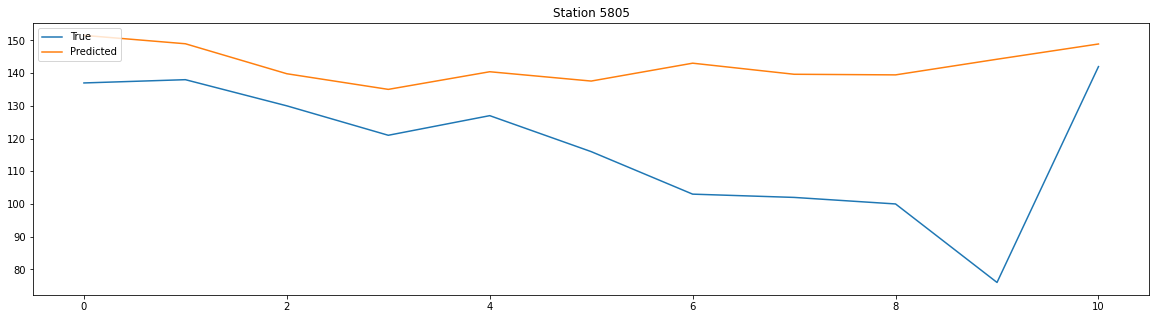

MAE: 25.576293566995417
Station 6022:


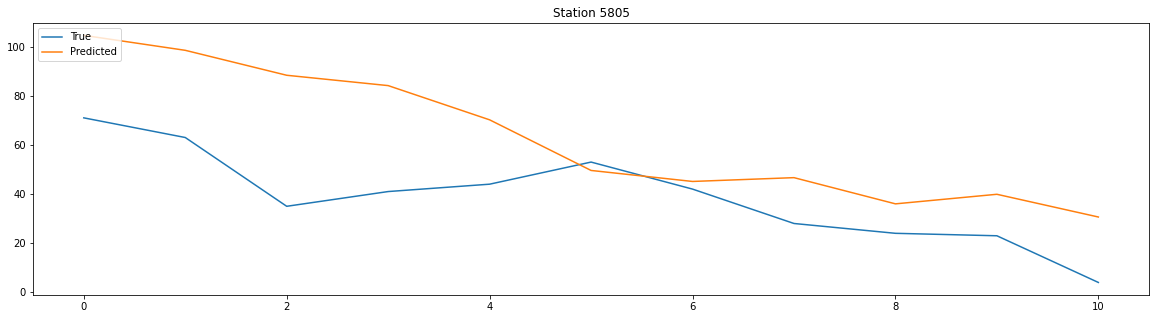

MAE: 31.501706020891174
Station 6027:


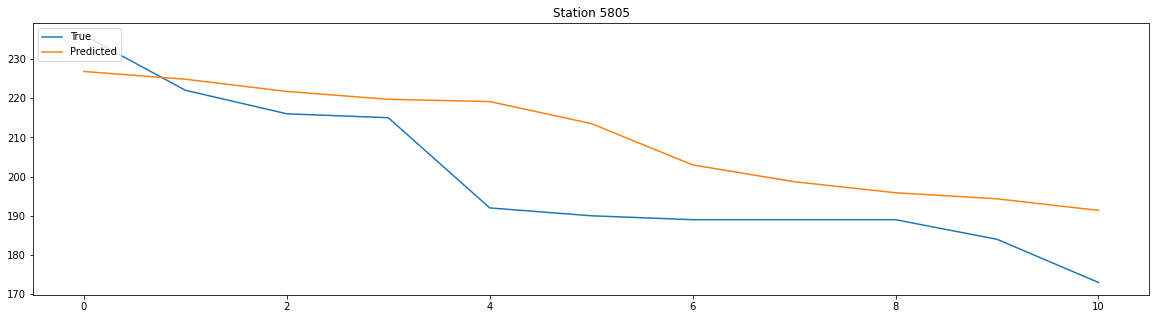

MAE: 20.615248120520725
Station 5004:


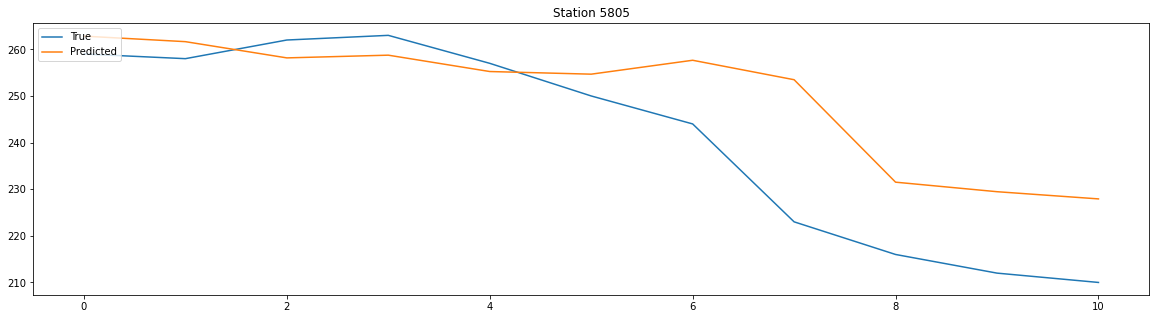

MAE: 19.878677746481145
Station 5012:


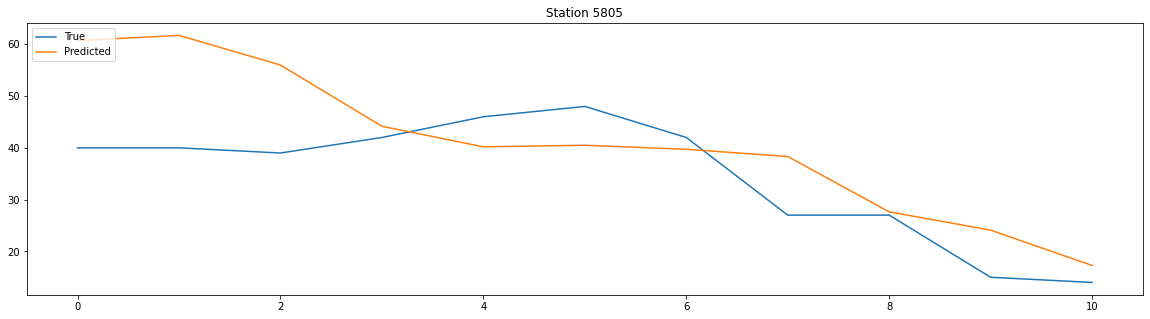

MAE: 14.997090237199767
Station 5024:


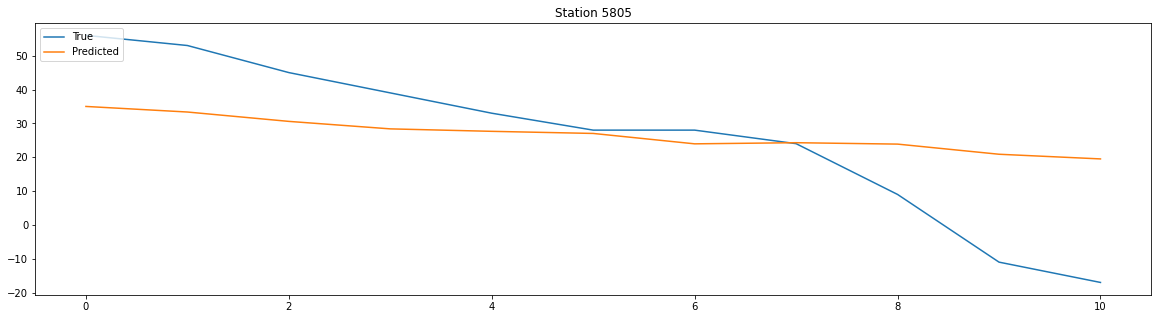

MAE: 18.555332514865338
Station 5805:


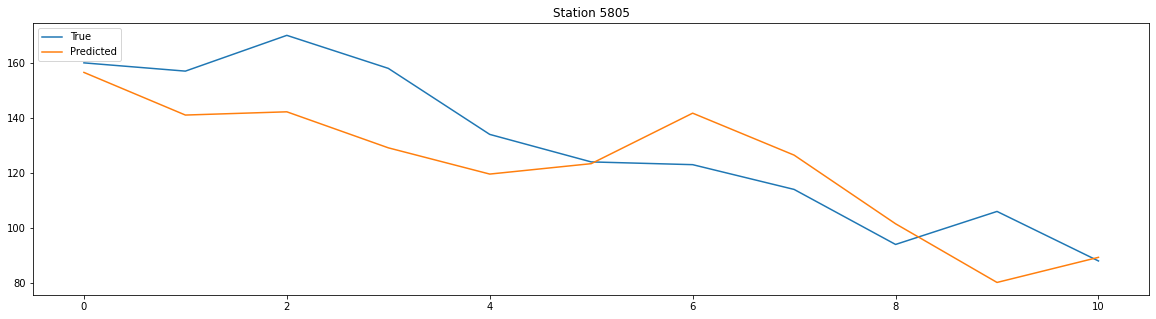

MAE: 29.54896955253664


In [ ]:
stations_validation = []

for target_station in station_ids:
  print(f'Station {target_station}:')
  
  X_train, y_train, X_test, y_test, target_mean, target_std = \
  custom_test_train_split(daily, pd.date_range('2019-11-01', '2019-11-11'), 
                          target_station)
  
  model.fit(X_train.repeat(3, axis=0), y_train.repeat(3, axis=0), 
            epochs=25, validation_steps=50, steps_per_epoch=300, verbose=0)

  mse, mae = model.evaluate(X_test, y_test, verbose=0)
  y_pred = model.predict(X_test)
  true_denorm, pred_denorm = plot_denormalized_prediction(target_mean, target_std,
                                                          y_test, y_pred, f'Station {test_station}')
  mae = np.abs(np.array(true_denorm) - np.array(pred_denorm)).mean()
  print(f'MAE: {mae}')

  # Добавляем данные в список station_validation
  stations_validation.append({'true_vals': true_denorm, 
                             'pred_vals': pred_denorm,
                             'mae': mae})

Как видно, предсказания выполняются с достаточной точностью (MAE < 50 для всех станций)